# GELU

**Descrição**  
A **GELU (Gaussian Error Linear Unit)** é uma função de ativação muito usada em redes neurais profundas (especialmente em **Transformers/GPT**). Diferente da ReLU, que “corta” valores negativos de forma abrupta, a GELU aplica uma **transição suave**, atenuando valores negativos em vez de zerá-los totalmente.

**Objetivo**  
Introduzir **não-linearidade** na rede de forma suave e estável, melhorando a capacidade do modelo de representar padrões complexos — algo particularmente útil em arquiteturas profundas, como as usadas em linguagem natural.

**Funcionamento**  
A definição conceitual da GELU é:

<img src="https://latex.codecogs.com/svg.image?\mathrm{GELU}(x)=x\,\Phi(x)" />

onde $\Phi(x)$ é a função de distribuição acumulada (CDF) da Normal padrão.  
Na prática, é comum usar a aproximação com `tanh` (mais eficiente):

<img src="https://latex.codecogs.com/svg.image?\mathrm{GELU}(x)\approx\frac{1}{2}\,x\left(1&plus;\tanh\left(\sqrt{\frac{2}{\pi}}\left(x&plus;0.044715\,x^{3}\right)\right)\right)" />

Em termos intuitivos, a GELU “filtra” $x$ por um fator suave dependente de $x$ (próximo de 0 para valores bem negativos e próximo de 1 para valores positivos), evitando um corte rígido em zero.


In [1]:
import torch
from torch import nn

A **GELU** (*Gaussian Error Linear Unit*) é uma função de ativação muito usada em modelos do tipo **Transformer/GPT**, especialmente nos blocos **feed-forward** (MLP). A ideia central é **“portar” o ReLU**: em vez de cortar tudo que é negativo de forma abrupta, a GELU **reduz gradualmente** valores negativos, mantendo uma transição suave.

## Intuição

Você pode pensar na GELU como:

- **ReLU:** “se for negativo, zera; se for positivo, mantém”
- **GELU:** “se for muito negativo, quase zera; se for perto de 0, atenua; se for positivo, tende a manter”

Isso ajuda porque a função é **suave** (derivável em todo lugar), o que pode estabilizar/beneficiar o treinamento em redes profundas.

## Aproximação usada na prática (tanh)

Na prática, muitas implementações usam uma aproximação muito comum (a que aparece no capítulo do livro):

<img src="https://latex.codecogs.com/svg.image?\mathrm{GELU}(x)\approx\frac{1}{2}\,x\left(1&plus;\tanh\left(\sqrt{\frac{2}{\pi}}\left(x&plus;0.044715\,x^{3}\right)\right)\right)" />

Essa aproximação é popular porque é **rápida**, **estável** e costuma ser suficiente para uso em Transformers.

## Comparação com ReLU

### ReLU

<img src="https://latex.codecogs.com/svg.image?\mathrm{ReLU}(x)=\max(0,x)" />


- Simples e rápida
- Tem um “corte” brusco em 0 (não é suave nesse ponto)

### GELU
- Suave em toda a faixa
- Valores negativos **não são zerados totalmente**: são apenas **atenuados**
- Muito comum em arquiteturas GPT/Transformer no MLP

## Por que a GELU aparece em Transformers?

Em Transformers, o bloco feed-forward (MLP) precisa de uma não-linearidade para:
- aumentar a capacidade do modelo de representar padrões complexos
- manter estabilidade ao empilhar muitas camadas

A GELU virou uma escolha frequente por ser **suave** e funcionar bem empiricamente nesse contexto.


In [2]:
class GELU(nn.Module):
    """
    Implementação do GELU (Gaussian Error Linear Unit) na forma aproximada
    com tanh, muito usada em arquiteturas tipo GPT.

    Fórmula (aproximação):
        GELU(x) = 0.5 * x * (1 + tanh( sqrt(2/pi) * (x + 0.044715 * x^3) ))

    Observações:
    - Esta é a aproximação popularizada no contexto de Transformers.
    - Mantém o dtype e o device do tensor de entrada.

    Exceções:
    --------
    TypeError
        Se a entrada não for um torch.Tensor.
    """

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Aplica a ativação GELU aproximada ao tensor de entrada.

        Parâmetros:
        ----------
        x : torch.Tensor
            Tensor de entrada.

        Retorno:
        -------
        torch.Tensor
            Tensor com GELU aplicado, mesmo shape do input.

        Exceções:
        --------
        TypeError
            Se x não for torch.Tensor.
        """
        if not isinstance(x, torch.Tensor):
            raise TypeError("x deve ser um torch.Tensor.")

        # Constantes no mesmo dtype/device do input para evitar casts/CPU<->GPU.
        sqrt_2_over_pi = torch.sqrt(
            torch.tensor(2.0 / torch.pi, dtype=x.dtype, device=x.device)
        )
        return (
            0.5
            * x
            * (1.0 + torch.tanh(sqrt_2_over_pi * (x + 0.044715 * torch.pow(x, 3))))
        )

In [3]:
def plot_activation_functions(
    x_min: float = -3.0,
    x_max: float = 3.0,
    num_points: int = 100,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Plota as funções de ativação GELU e ReLU em subplots lado a lado.

    Parâmetros:
    ----------
    x_min : float, default = -3.0
        Valor mínimo do eixo x.
    x_max : float, default = 3.0
        Valor máximo do eixo x.
    num_points : int, default = 100
        Quantidade de pontos no intervalo [x_min, x_max].

    Retorno:
    -------
    tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        (x, y_gelu, y_relu), onde:
        - x é o tensor de entrada
        - y_gelu = GELU(x)
        - y_relu = ReLU(x)

    Exceções:
    --------
    ValueError
        Se num_points < 2 ou x_max <= x_min.
    TypeError
        Se não for possível converter parâmetros numéricos.
    """
    try:
        x_min_f = float(x_min)
        x_max_f = float(x_max)
        num_points_i = int(num_points)
    except (TypeError, ValueError) as e:
        raise TypeError(
            "x_min, x_max devem ser numéricos e num_points deve ser int."
        ) from e

    if x_max_f <= x_min_f:
        raise ValueError("x_max deve ser maior que x_min.")
    if num_points_i < 2:
        raise ValueError("num_points deve ser >= 2.")

    import matplotlib.pyplot as plt  # import local para manter dependência opcional

    gelu = GELU()
    relu = nn.ReLU()

    x = torch.linspace(x_min_f, x_max_f, num_points_i)
    y_gelu = gelu(x)
    y_relu = relu(x)

    plt.figure(figsize=(8, 3))
    for i, (y, label) in enumerate(((y_gelu, "GELU"), (y_relu, "ReLU")), start=1):
        plt.subplot(1, 2, i)
        plt.plot(x, y)
        plt.title(f"{label} activation function")
        plt.xlabel("x")
        plt.ylabel(f"{label}(x)")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    return x, y_gelu, y_relu

x: tensor([-3., -2., -1.,  0.,  1.,  2.,  3.])
GELU(x): tensor([-0.0036, -0.0454, -0.1588,  0.0000,  0.8412,  1.9546,  2.9964])


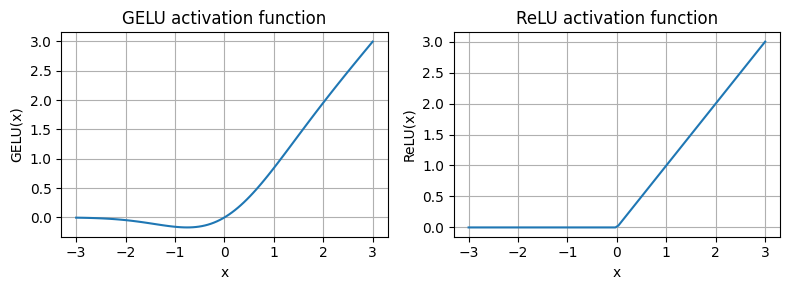

In [4]:
# 1) Usando a camada diretamente
gelu = GELU()
x = torch.tensor([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
print("x:", x)
print("GELU(x):", gelu(x))

# 2) Plotando GELU vs ReLU (retorna também os tensores)
_ = plot_activation_functions()